In [1]:
import appdirs, os
# Monkey-patch appdirs.user_cache_dir to an unwritable location
appdirs.user_cache_dir = lambda _: '/tmp/.cache'
os.environ['MPLCONFIGDIR'] = "/tmp/.cache/matplotlib"

In [2]:
import os
from tqdm import tqdm

import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.models as models
from torch import nn
from torch import optim

import numpy as np
from PIL import Image
import pickle as pkl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import precision_recall_curve, auc, roc_curve

from captum.attr import Saliency, IntegratedGradients, GradientShap, NoiseTunnel, GuidedBackprop
from captum.attr import visualization as viz

import util
from DuckDataset import DuckDataset

%load_ext autoreload
%autoreload 2

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [5]:
# dataset class 
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, 
                 images, 
                 transform = None,
            ):
            super(ImageDataset, self).__init__()
            self.images = images
            self.transform = transform    

    def __getitem__(self, index):
        assert index < len(self.images), 'Invalid index!'
        # get the image
        img = self.images[index]
        # apply transform
        if self.transform is not None:
            img = self.transform(img)
        return img, 0
            
    def __len__(self):
        return len(self.images)

In [6]:
# load visualisation examples
examples = pkl.load(open(f'data/duck_vis_examples.pkl', 'rb'))

imgs, labels, duck_positions, masks = examples

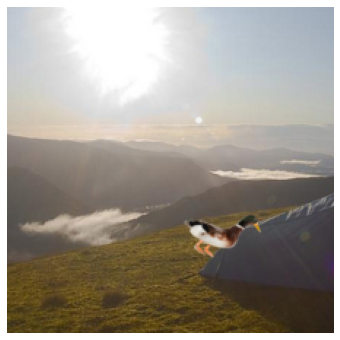

In [7]:
# show one example 

i = 5
fig = plt.figure(figsize=(6, 6))
plt.imshow(imgs[i].permute(1, 2, 0))
plt.axis('off')
plt.savefig(f'figures/duck{i}.pdf')
plt.show()


In [ ]:
# explain example images with methods using different trained models

methods = {'g': 'gradient',
           'ig': 'integrated gradients',
           'gs': 'gradient shap',
           'gbp': 'guided backprop'
          }

net_name = 'resnet18'
# set these accordingly
model_name = 'duck_id005_model'
model_dir = '/mnt/qb/luxburg/fgoeppert26/models' 

n_images = 25
n_models = 100

for meth,label in methods.items():
    
    model_attributions = []
    
    for aid in tqdm(range(n_models)):
        fname = f'{model_dir}/{model_name}_{net_name}_{aid}.pkl'
        if not os.path.exists(fname): # some jobs might have failed
            continue

        net = models.resnet18()
        net.fc = nn.Linear(512, 2)

        net.load_state_dict(torch.load(fname))
        net.to('cuda')
        net.eval()


        attributions = [] 
        for i in range(n_images):
            img = imgs[i]

            img = normalize(img).to(device).unsqueeze(0)
            output = net(img)
            prediction = output.softmax(dim=1).argmax().item()
            
            if meth == 'g':
                grad = Saliency(net)
                attribution = grad.attribute(img, target=prediction, abs=False)
            if meth == 'ig':
                baselines = torch.zeros(img.shape).to(device)
                nt = NoiseTunnel(IntegratedGradients(net))
                attribution = nt.attribute(img, baselines = baselines, target=prediction )#, n_steps=200)
            if meth == 'gs':
                gs = GradientShap(net)
                baselines = torch.rand((5,img.shape[1],img.shape[2],img.shape[3])).to(device)
                attribution = gs.attribute(img,n_samples=50, stdevs=0.1, baselines=baselines, target=prediction)
            if meth == 'gbp':
                gbp =  GuidedBackprop(net)
                attribution = gbp.attribute(img,target=prediction)
                
            
            attributions.append(attribution.detach().cpu())

        model_attributions.append(attributions)
        net.to('cpu')
        
        pkl.dump(model_attributions, open(f'{meth}_{model_name}_attributions.pkl', 'wb'))

        

# (Average of N) Explanations of 100 ResNet18 on Ducks in ImageNet-pictures 

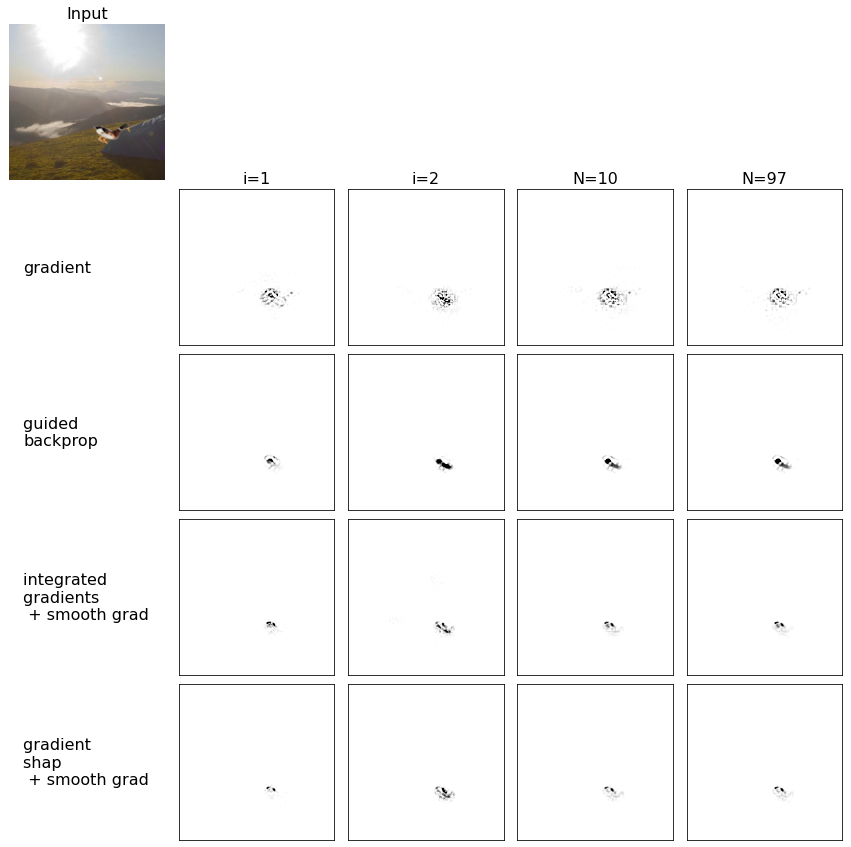

In [10]:
# plot attributions of one image 

methods = {'g': 'gradient',
           'gbp': 'guided \nbackprop',
           'ig': 'integrated \ngradients \n + smooth grad',
           'gs': 'gradient \nshap \n + smooth grad'
          }

i = 5

model_name = 'duck_id005_model'
img = imgs[i]

n_methods = len(methods)
N = [0,1,range(10),range(97)]
n = len(N)

fig, ax = plt.subplots(nrows=n_methods+1, ncols= n+1, figsize=((n+1)*3, (n_methods+1)*3))
ax[0,0].imshow(imgs[i].permute(1, 2, 0))
ax[0,0].axis('off')
ax[0,0].set_title('Input',fontsize = 16)

default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                             [(0, '#ffffff'),
                                              (0.5, '#000000'),
                                              (1, '#000000')], N=256)

for k in range(1,n_methods+1):
    ax[k,0].axis('off')

for j in range(1,n+1):
    ax[0,j].axis('off')
    
r = 1
for m,l in methods.items():
    
    model_attributions = pkl.load(open(f'attributions/{m}_{model_name}_attributions.pkl', 'rb'))
    
    a = torch.stack([model_attributions[j][i] for j in range(len(model_attributions))])

    #a = torch.sum(a,axis =2, keepdims = True )
    a = a.cpu().detach().numpy()
    
    c = 1
    for n_ in N:
        
        attribution = np.mean(a[n_], axis = 0).squeeze()
        img = imgs[i].squeeze().cpu().detach().numpy()
        
        viz.visualize_image_attr(np.transpose(attribution, (1,2,0)),
                                 np.transpose(attribution, (1,2,0)),   # img
                                     method ="heat_map",
                                     cmap = default_cmap,
                                     #show_colorbar=True,
                                     sign = 'positive',
                                     #outlier_perc=2,
                                     #title = f'N={n_}',
                                     use_pyplot = False,
                                     plt_fig_axis=(fig, ax[r,c]))
        
        if c == 1:
            ax[r,c].text(-224,112,f'{l}',fontsize = 16,va = 'center')
        if r == 1:
            if type(n_) == range:
                txt = f'N={n_[-1]+1}'
            else:
                txt = f'i={n_+1}'
            ax[r,c].set_title(txt, fontsize = 16)
        c += 1
    r += 1

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.06, hspace=0.06)
plt.savefig(f'figures/{model_name}_plot_{i}.pdf',bbox_inches='tight',pad_inches=0.01)
plt.show()


## numerical evaluation

In [11]:
def IoU(attribution,mask,alpha):
    
    attr = attribution.copy()
    attr[attr > np.quantile(attr,alpha)] = 1
    
    intersection =  mask * attr
    union = mask + attr
    union[union >= 1] = 1

    iou = intersection.sum() / union.sum()
    
    return iou 

In [ ]:
# final numerical evaluation 

methods = {#'g': 'gradient',
           'ig': 'integrated gradients',
           'gbp': 'guided backprop',
           #'gs': 'gradient shap'
          }

n_images = 25
n_models = 100
                 
N = [1,10,100]

alphas = 1-np.logspace(-3,0,100) #?
#alphas = np.linspace(0,1,100) #?
model_name = 'duck_id005_model'

k = 1
for m,l in methods.items():
    
    iou_m = []
    auprc_m = []
    
    for i in tqdm(range(n_images)):
        
        model_attributions = pkl.load(open(f'{m}_{model_name}_attributions.pkl', 'rb'))
        a = torch.stack([model_attributions[j][i] for j in range(len(model_attributions))]).cpu().detach().numpy()

        a = np.sum(a,axis =2) # sum attributions over channels
    
        iou_img = []
        auprc_img = []
        
        for n_ in N:
            
            iou_k = []
            auprc_k = []
            
            K = int(np.sqrt(n_models/n_))
            for k in range(K): 
            
                attribution = np.mean(a[k*n_:(k+1)*n_], axis = 0).squeeze()
            
                iou_n = []
                for alpha in alphas:
                    iou_n.append(IoU(attribution, masks[i], alpha ))
            
                iou_k.append(np.array(iou_n))
            
                p, r, _ = precision_recall_curve(masks[i].flatten(),attribution.flatten())

                auprc_k.append(auc(r,p))
                
            iou_img.append(np.mean(np.array(iou_k),axis =0))
            auprc_img.append(np.mean(auprc_k))
        
        iou_m.append(np.array(iou_img))
        auprc_m.append(auprc_img)
    
    auprc_m = np.mean(np.array(auprc_m),axis = 0)
    iou_m = np.mean(np.array(iou_m),axis = 0)
    
    pkl.dump(auprc_m, open(f'results/{m}_{model_name}_auprc.pkl', 'wb'))
    pkl.dump(iou_m, open(f'results/{m}_{model_name}_iou.pkl', 'wb'))
    
    print(f'{l}:{auprc_m}')
    
    #plt.suptitle(f'Mean Intersection over Union (IoU) over {n_images} images')
    
    plt.figure(figsize=(6,6))
    for i in range(iou_m.shape[0]):
        plt.plot(alphas,iou_m[i], label = f'N={N[i]}')
    plt.legend()
    plt.xlabel('percentile excluded')
    plt.ylabel('IoU')
    plt.title(f'{l} ')
    k += 1
    plt.show()


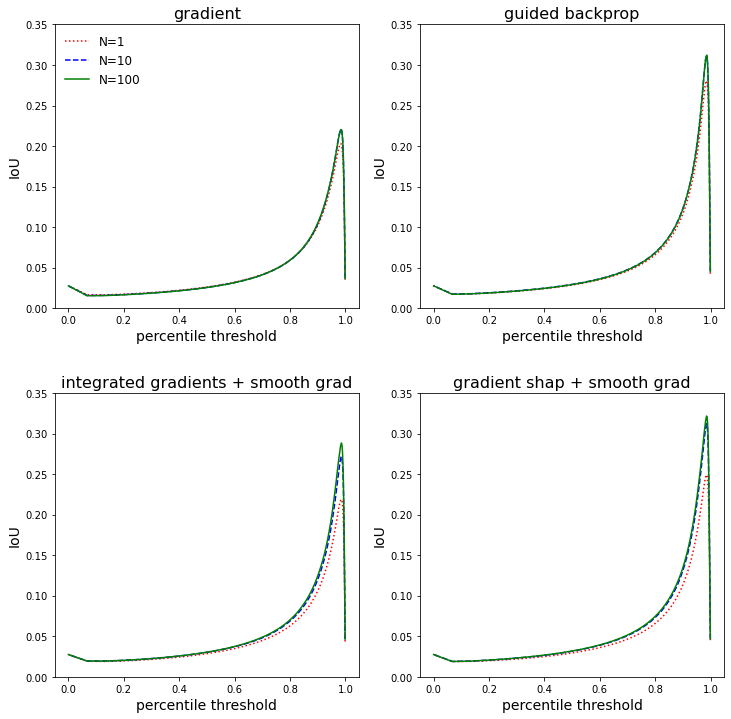

In [18]:
alphas = 1-np.logspace(-3,0,100)
model_name = 'duck_id005_model'
N = [1,10,100]

methods = {'g': 'gradient',
           'gbp': 'guided backprop',
           'ig': 'integrated gradients + smooth grad',
           'gs': 'gradient shap + smooth grad'
          }

colors = ['r','b','g']
styles = [':','--','-']

fig, ax = plt.subplots(nrows=2, ncols= 2, figsize=(12,12))
ax = ax.ravel()
k = 0
for m,l in methods.items():
    iou_m = pkl.load(open(f'results/{m}_{model_name}_iou.pkl', 'rb'))
    for i in range(iou_m.shape[0]):
        
        ax[k].plot(alphas,iou_m[i], label = f'N={N[i]}', linestyle = styles[i], color = colors[i])
    if k == 0:
        ax[k].legend(loc = 'upper left', fontsize = 12,frameon=False)
    ax[k].set_xlabel('percentile threshold', fontsize = 14)
    ax[k].set_ylabel('IoU',fontsize = 14)
    ax[k].set_title(f'{l}',fontsize = 16)
    ax[k].set_ylim(0,0.35)
    #ax[k].set_xscale('log')
    #ax[k].set_xlim(0,1)
    
    #T = [0,0.5,0.9,1.0]
    #idx = [np.argmin(abs(t-alphas)) for t in T]
    #ax[k].set_xticks([(99-i) for i in idx])
    #ax[k].set_xticklabels([str(np.round(alphas[i],1)) for i in idx])
    k +=1 
                           
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.3)
plt.savefig(f'figures/duck_metricsA.pdf',bbox_inches='tight',pad_inches=0.01)
plt.show()

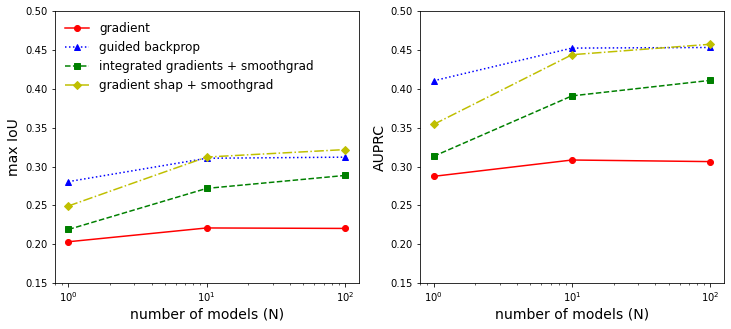

In [19]:
alphas = 1-np.logspace(-3,0,100)
model_name = 'duck_id005_model'
N = [1,10,100]

methods = {'g': 'gradient',
           'gbp': 'guided backprop',
           'ig': 'integrated gradients + smoothgrad',
           'gs': 'gradient shap + smoothgrad'
          }

colors = ['r','b','g','y']
styles = ['-',':','--','-.']
markers = ['o','^','s','D']

fig, ax = plt.subplots(nrows=1, ncols= 2, figsize=(12,5))
#ax = ax.ravel()
i = 0

for m,l in methods.items():
    iou = pkl.load(open(f'results/{m}_{model_name}_iou.pkl', 'rb'))
    max_iou = np.amax(iou,axis = 1)
    auprc= pkl.load(open(f'results/{m}_{model_name}_auprc.pkl', 'rb'))
    
    ax[0].plot(N,max_iou, label = f'{l}', linestyle = styles[i], color = colors[i], marker = markers[i])
    ax[1].plot(N,auprc, label = f'{l}', linestyle = styles[i], color = colors[i], marker = markers[i])
    
    i +=1 
    
ax[0].legend(loc = 'upper left', fontsize = 12,frameon=False)

ax[0].set_ylabel('max IoU',fontsize = 14)

ax[1].set_ylabel('AUPRC',fontsize = 14)

for ax in ax.ravel():
    ax.set_ylim(0.15,0.5)
    ax.set_xscale('log')
    ax.set_xticks([1,10,100])
    ax.set_xlabel('number of models (N)', fontsize = 14)
    

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.3)
plt.savefig(f'figures/duck_metricsB.pdf',bbox_inches='tight',pad_inches=0.01)
plt.show()